# RNSA Bone Age
Fine-tuned pre-trained VGG16, including both image and gender inputs

In [0]:
import pandas as pd
import numpy as np
import math
import random
import itertools
import pickle

from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import layers, models, regularizers, optimizers
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Flatten, Dense, Dropout, concatenate
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from keras.preprocessing import image as krs_image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'SHARED_LINK_ID'}) 
downloaded.GetContentFile('train.csv')  

In [0]:
downloaded = drive.CreateFile({'id':'SHARED_LINK_ID'}) 
downloaded.GetContentFile('test.csv')  

In [0]:
train_val = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

In [0]:
train, val = train_test_split(train_val.copy(), test_size=0.2, random_state=2020)

In [0]:
train.shape, val.shape, test.shape

((10088, 3), (2523, 3), (200, 3))

## Descriptives of dataset

In [0]:
train['gender'] = train.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)
val['gender'] = val.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)
test['gender'] = test.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)

### Age Distributions

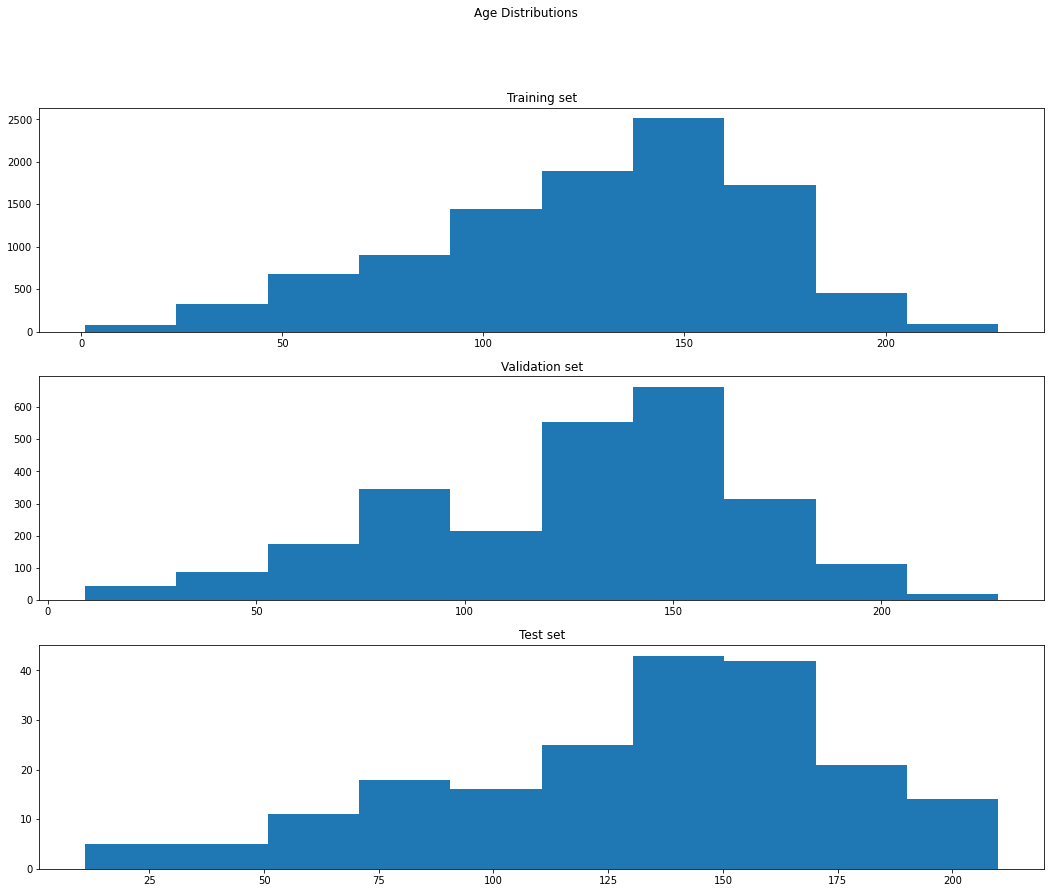

In [0]:
fig = plt.figure(figsize=(18,14)) 
fig_dims = (3, 1)
fig.suptitle('Age Distributions')

plt.subplot2grid(fig_dims, (0, 0))
plt.hist(train['boneage'])
plt.title('Training set')

plt.subplot2grid(fig_dims, (1, 0))
plt.hist(val['boneage'])
plt.title('Validation set')

plt.subplot2grid(fig_dims, (2, 0))
plt.hist(test['boneage'])
plt.title('Test set');

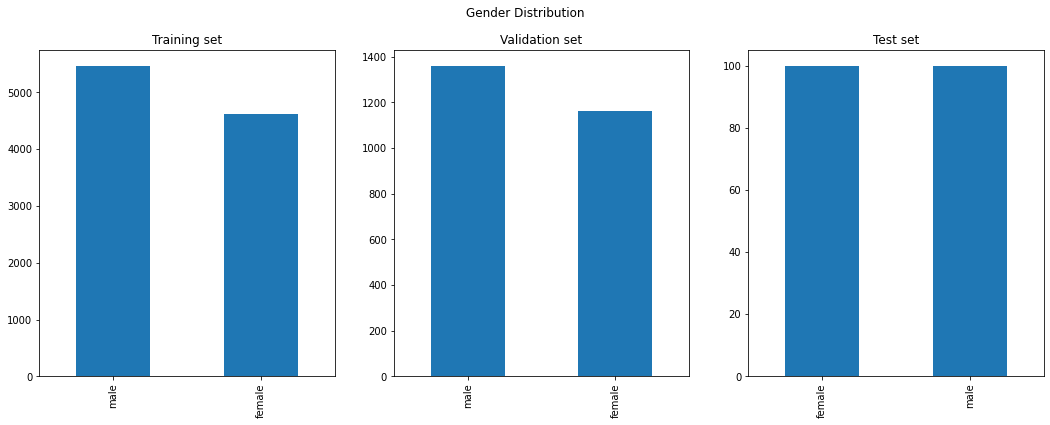

In [0]:
fig = plt.figure(figsize=(18,6)) 
fig_dims = (1, 3)
fig.suptitle('Gender Distribution')

plt.subplot2grid(fig_dims, (0, 0))
train['gender'].value_counts().plot(kind='bar', title='Training set');

plt.subplot2grid(fig_dims, (0, 1))
val['gender'].value_counts().plot(kind='bar', title='Validation set');

plt.subplot2grid(fig_dims, (0, 2))
test['gender'].value_counts().plot(kind='bar', title='Test set');

## Gender

In [0]:
train['is_male'] = train.apply(lambda row: 1 if row['male']==True else 0, axis=1)
val['is_male'] = val.apply(lambda row: 1 if row['male']==True else 0, axis=1)
test['is_male'] = test.apply(lambda row: 1 if row['male']==True else 0, axis=1)

## Upload images from drive

In [0]:
download = drive.CreateFile({'id': 'SHARED_LINK_ID'})
download.GetContentFile('resized-padded.zip')

In [0]:
!unzip -q 'resized-padded.zip'

### Add Image Path to dataframes

In [0]:
train['img_path'] = 'resized_padded/training/' + train['img_path']
val['img_path'] = 'resized_padded/training/' + val['img_path']
test['img_path'] = 'resized_padded/test/' + test['img_path']

## Custom Data Generator to load Image and Gender data

Code was inspired by: https://stackoverflow.com/questions/55266249/create-a-mixed-data-generator-images-csv-in-keras

In [0]:
def custom_generator(df, batch_size, datagen, split, shuffle=True):
    """
    Generator for both image and gender input.
    Takes as input a dataframe with information on image path, gender and bone age, an empty keras ImageDataGenerator 
    and the split as a string (e.g., 'train', 'val', 'test')
    """
    i = 0
    image_ids = list(df.index)
    if shuffle:    
        random.shuffle(image_ids)
    while True:
        batch = {'images': [], 'gender': [], 'labels': []}
        for b in range(batch_size):
            if i == len(image_ids):
                i = 0
                if shuffle:
                    random.shuffle(image_ids)
                break
            # Read image from list and convert to array
            image_path = df.loc[image_ids[i], 'img_path']
            image = krs_image.load_img(image_path, target_size=(256, 256))
            image = krs_image.img_to_array(image)
            image = image * (1./255)

            # Random transformations for training set
            if split=='train':
                train_datagen_args = dict(
                                      theta=random.randint(0, 20), 
                                      tx=random.randint(-20, 20), 
                                      ty=random.randint(-20, 20),
                                      zx=random.uniform(0.8, 1),
                                      zy=random.uniform(0.8, 1),
                                      flip_horizontal=np.random.choice([True, False]),
                                  )
                image = datagen.apply_transform(image, transform_parameters=train_datagen_args)

            # Read data from csv using the name of current image
            gender = df.loc[image_ids[i], 'is_male']
            label = df.loc[image_ids[i], 'boneage']

            batch['images'].append(image)
            batch['gender'].append(gender)
            batch['labels'].append(label)
            
            i += 1

        batch['images'] = np.array(batch['images'])
        batch['gender'] = np.array(batch['gender'])
        batch['labels'] = np.array(batch['labels'])

        yield [batch['images'], batch['gender']], batch['labels']

In [0]:
# Create an empty data generator
datagen = ImageDataGenerator()

In [0]:
train_generator = custom_generator(train, 64, datagen, 'train')
val_generator = custom_generator(val, 64, datagen, 'val')
test_generator = custom_generator(test, 200, datagen, 'test')

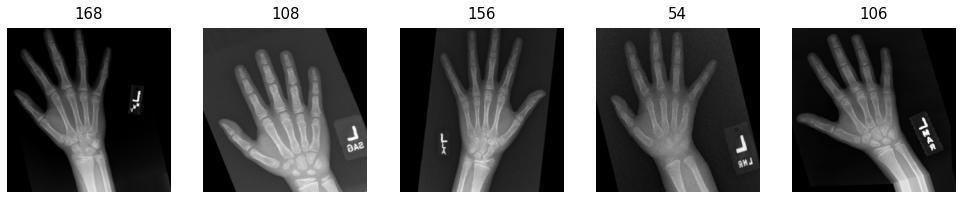

In [0]:
def plot_images(generator):
    """
    Plots 5 sample images.
    Takes as input a generator instance.
    """
    X, y = next(generator)
    X = X[0]
    fig, axes = plt.subplots(1, len(X[15:20]), figsize=(17, 5))
    for idx, ax in enumerate(axes):
        ax.axis('off')
        ax.imshow(X[idx][:,:,::-1])
        ax.set_title(y[idx], size=15, pad=10)

plot_images(train_generator) # Data augmentation

## Deep Learning


### Baseline

As in initial baseline for the regression model, we can look at a central tendency measure of the validation set. In this case, we will use the mean of the validation set as the initial baseline.

In [0]:
mean_validation_set = np.mean(val.boneage)
y_pred = np.array(len(val.boneage) * [mean_validation_set])
y_true = val.boneage
baseline_mae = mean_absolute_error(y_true, y_pred)
baseline_mse = mean_squared_error(y_true, y_pred)
print('The initial baseline for the problem is a Mean Absolute Error of {} months.'.format(round(baseline_mae,2)))
print('The initial baseline for the problem is a Mean Squared Error of {}.'.format(round(baseline_mse,2)))

The initial baseline for the problem is a Mean Absolute Error of 33.68 months.
The initial baseline for the problem is a Mean Squared Error of 1683.65.


A more domain-based baseline for this project would be the MAE of pediatric
radiologists. Reddy et al. (2019) have conducted an experiment with three radiologists on the RSNA bone age dataset. The authors found a Mean Absolute Error of 6.0 months for radiologist on the RSNA bone age dataset.

__Reference__

Reddy, N. E., Rayan, J. C., Annapragada, A. V., Mahmood, N. F., Scheslinger, A. E., Zhang, W., & Kan, J. H. (2020). Bone age determination using only the index finger: a novel approach using a convolutional neural network compared with human radiologists. _Pediatric Radiology_, 50(4), 516-523.

### Fine-tuned pre-trained model

For this research, I employ a model with two inputs, namely image data and gender. For the gender input, I use one dense hidden layer with 8 neurons. For the image model, I use a pre-trained (fine-tuned) VGG16 model. Outputs of these models are then concatenated and fed through one dense hidden layer to allow the model to to reason out the relationship between the pixel and gender information (Cicero & Bilbily, 2017).

Based on the paper by Sarić et al. (2019), where a fine-tuned VGG16 model is employed for the task of bone age prediction on the RSNA dataset, I use the Adam optimizer. For tuning, I consider the number of fine-tuned (i.e., unfrozen layers) in the VGG16 architecture, the number of hidden neurons in the dense hidden layer after the concatenated layer and the learning rate. 

Cicero, M., & Bilbily, A. (2017). Machine Learning and the Future of Radiology: How we won the 2017 RSNA ML Challenge. Retrieved from https://www.16bit.ai/blog/ml-and-future-of-radiology

Sarić, R., Kevrić, J., Čustović, E., Jokić, D., & Beganović, N. (2019). Evaluation of Skeletal Gender and Maturity for Hand Radiographs using Deep Convolutional Neural Networks. In 2019 6th International Conference on Control, Decision and Information Technologies (CoDIT) (pp. 1115-1120). IEEE.

In [0]:
def build_model(trainable=None,
                dense_hidden_neurons=16,
                lr=0.001):
    """
    Builds a model with incorporated VGG16 to handle image input and a dense layer for gender input.
    Arguments:
    - trainable: number of trainable layers in VGG16. One of:
        - 'last_layer'
        - 'last_block'
    - dense_hidden_neurons: number of hidden neurons in the last hidden layer after concatenation of gender 
    and image networks.
    - lr: learning rate
    """
    ## MLP
    # define our MLP network for the gender input
    mlp = Sequential()
    mlp.add(Dense(8, input_dim=1, activation="relu"))

    ## VGG16
    # Instantiate VGG16 model trained on imagenet
    pre_trained_model = VGG16(weights='imagenet', include_top=False,
                              input_shape=(256, 256, 3))
  
    # If layers must be set to trainable, do that here
    if trainable == 'last_layer':
        from_trainable = 17

    elif trainable == 'last_block':
        from_trainable = 15

    else: from_trainable=18

    # Set layers to trainable
    for layer in pre_trained_model.layers[from_trainable:]: 
        layer.trainable = True
    # Freeze all other layers
    for layer in pre_trained_model.layers[:from_trainable]: 
        layer.trainable = False

    # Add a Global Average Pooling layer to reduce the number of parameters in the model
    pooling = layers.GlobalAveragePooling2D()(pre_trained_model.output)

    # Build new model structure
    vgg16 = Model(inputs=pre_trained_model.input, outputs=pooling)

    # Concatenate
    combined_input = concatenate([mlp.output, vgg16.output])

    add_layer = Dense(dense_hidden_neurons, activation='relu')(combined_input)

    # Add output layer for regression
    output_layer = Dense(1, activation='linear')(add_layer)

    # Final model
    model = Model(inputs=[vgg16.input, mlp.input], outputs=output_layer)

    optim = keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optim,
                  loss='mse',
                  metrics=['mae'])

    return model

58892288/58889256 [==============================] - 6s 0us/step


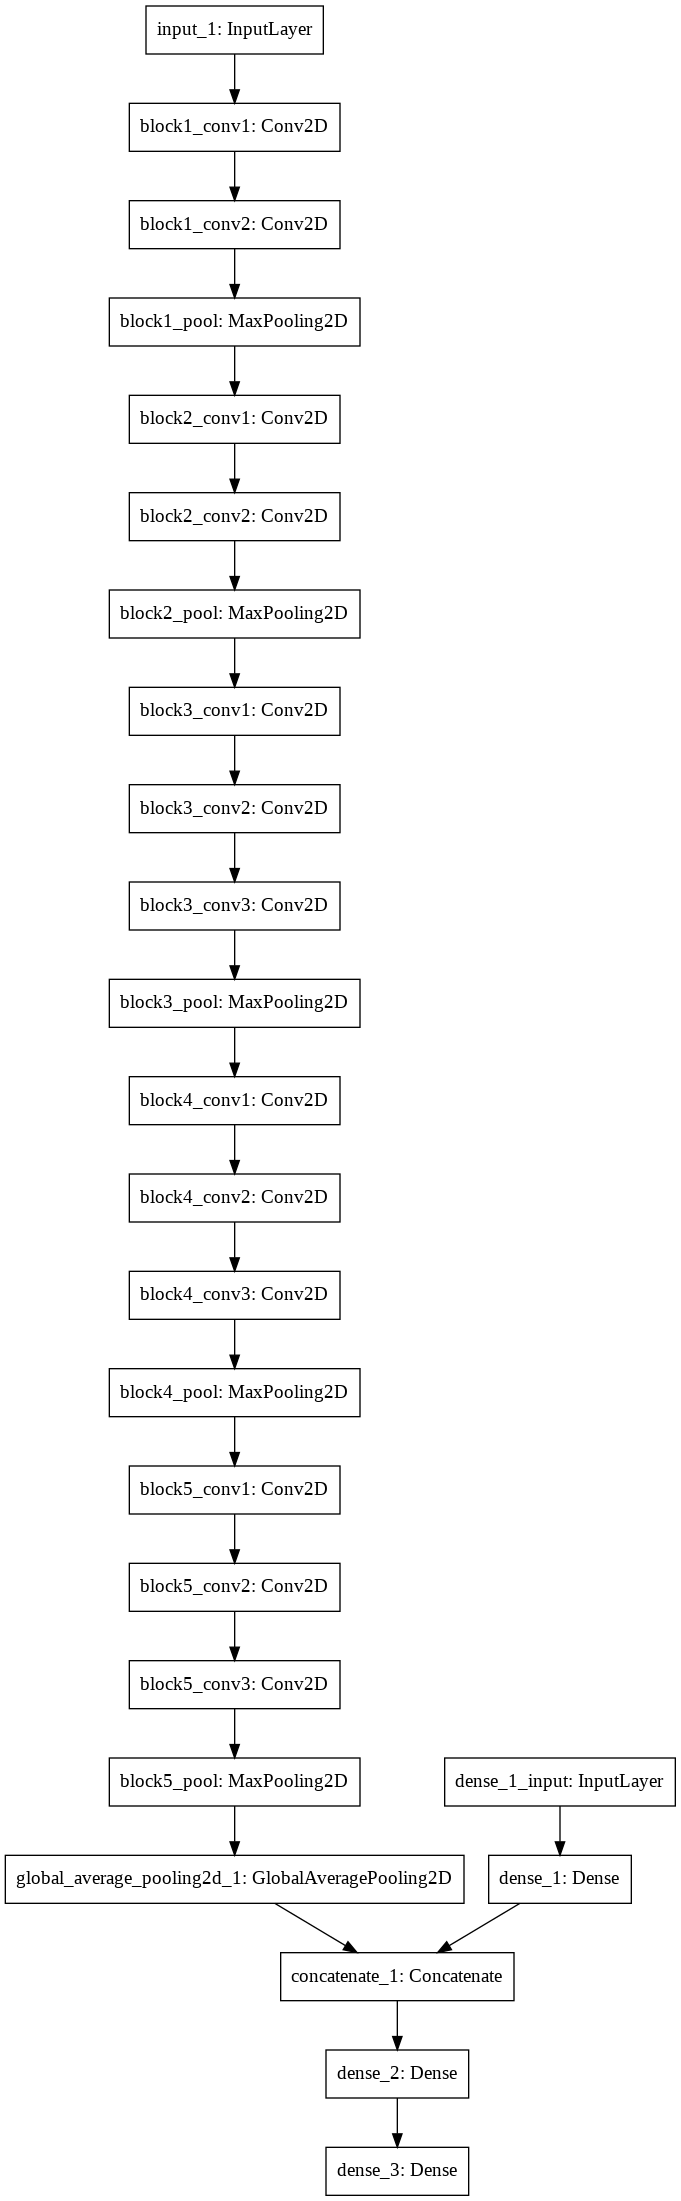

In [0]:
model = build_model()
plot_model(model)

### Manual Tuning

Because of computational restrictions due to resource constraints, I could not do any structured hyperparameter tuning (e.g., grid search, hyperopt). Therefore, I did some manual tuning on the following three hyperparameters:
* layers trainable in pre-trained model
* dense hidden neurons in last dense hidden layer
* learning rate

For most other untuned hyperparameters, I use values that are stated in academic papers on the RSNA Bone Age dataset.

In [0]:
def fit_model(model, epochs=30, verbose=2):
    """
    Fits model on train_generator and validates on val_generator. 
    Takes as input:
    - model: model to train
    - epochs: number of epochs
    - verbose: verbosity of fit_generator
    """
    early_stopping = EarlyStopping(monitor='val_mae', patience=10)

    checkpointer = ModelCheckpoint(filepath='keras_weights_{}.hdf5'.format(model.name),
                                   monitor='val_mae', 
                                   verbose=0, 
                                   save_best_only=True)

    callbacks = [early_stopping, checkpointer]
    return model.fit_generator(train_generator,
                               epochs=epochs,
                               validation_data=val_generator,
                               steps_per_epoch=math.ceil(len(train)/64),
                               validation_steps=math.ceil(len(val)/64),
                               callbacks=callbacks,
                               verbose=verbose)

In [0]:
def plot_history(history):
    """
    Plot train/validation MAE and train/validation loss (MSE) of trained model.
    Takes as input the history.history dictionary of a trained model. 
    """
    mae = history['mae']
    val_mae = history['val_mae']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(mae)+1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle('Training and Validation MAE and Loss')

    ax1.plot(epochs, mae)
    ax1.plot(epochs, val_mae)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MAE')
    ax1.set_title('MAE')
    ax1.legend(['training', 'validation'])

    ax2.plot(epochs, loss)
    ax2.plot(epochs, val_loss)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss')
    ax2.legend(['training', 'validation'])

#### Define search space

In [0]:
trainable = ['none', 'last_layer', 'last_block']
dense_hidden_neurons = [16, 32]
lr = [0.001, 0.0001]

search_space = [{'trainable': train,
                 'dense_hidden_neurons': neurons,
                 'lr': learning_rate} 
                for train, neurons, learning_rate in list(itertools.product(trainable, dense_hidden_neurons, lr))]

trained_models = {'model_{}'.format(i+1): {'params': search_space[i],
                                   'result': None} 
                  for i in range(len(search_space))}

In [0]:
def train_and_save(model_nr, epochs=30):
    """
    Trains one of the models with parameters within the search space and downloads results (hdf5 file with model 
    and weights and dictionary with trained_models and history of trained models so far) to local PC.
    Takes as input:
    - model_nr: the number of de model as defined above that we are trained
    - epochs: number of epochs for fit_model
    """
    model = build_model(**trained_models[model_nr]['params'])
    model.name = model_nr
    history = fit_model(model, epochs=epochs)
    files.download('keras_weights_{}.hdf5'.format(model_nr))

    trained_models[model_nr]['result'] = history.history

    with open('{}.pickle'.format(model_nr), 'wb') as file:
        pickle.dump(trained_models, file)

    files.download('{}.pickle'.format(model_nr))
    return trained_models

In [0]:
def model_params_results(model_nr):
    """
    Prints results (parameters, best validation loss and best MAE) of a trained model
    """
    print('Parameters of {}:'.format(model_nr), trained_models[model_nr]['params'])
    print('Best validation loss loss of {}:'.format(model_nr), 
          round(np.min(trained_models[model_nr]['result']['val_loss']), 2))
    print('Best validation MAE of {}:'.format(model_nr), 
          round(np.min(trained_models[model_nr]['result']['val_mae']), 2), 'months')

#### Training

In [0]:
trained_models = train_and_save('model_1')

Epoch 1/30
 - 217s - loss: 14620.6298 - mae: 113.3028 - val_loss: 9825.3174 - val_mae: 93.7304
Epoch 2/30
 - 201s - loss: 6201.9486 - mae: 68.8841 - val_loss: 2260.3701 - val_mae: 46.7401
Epoch 3/30
 - 202s - loss: 2137.9314 - mae: 38.9039 - val_loss: 1557.8923 - val_mae: 34.8789
Epoch 4/30
 - 203s - loss: 1782.1258 - mae: 34.4415 - val_loss: 2132.0544 - val_mae: 34.1346
Epoch 5/30
 - 202s - loss: 1762.5567 - mae: 34.0372 - val_loss: 1373.2283 - val_mae: 33.9851
Epoch 6/30
 - 202s - loss: 1739.5572 - mae: 33.7310 - val_loss: 2666.6787 - val_mae: 33.7517
Epoch 7/30
 - 202s - loss: 1724.2454 - mae: 33.6548 - val_loss: 1907.1904 - val_mae: 33.5739
Epoch 8/30
 - 202s - loss: 1707.6164 - mae: 33.4504 - val_loss: 995.3689 - val_mae: 33.3324
Epoch 9/30
 - 202s - loss: 1681.2405 - mae: 33.1387 - val_loss: 982.9911 - val_mae: 33.1152
Epoch 10/30
 - 201s - loss: 1671.0299 - mae: 33.0118 - val_loss: 2676.9895 - val_mae: 32.9428
Epoch 11/30
 - 201s - loss: 1646.4651 - mae: 32.8282 - val_loss: 1361

Parameters of model_1: {'trainable': 'none', 'dense_hidden_neurons': 16, 'lr': 0.001}
Best validation loss loss of model_1: 816.76
Best validation MAE of model_1: 28.92 months


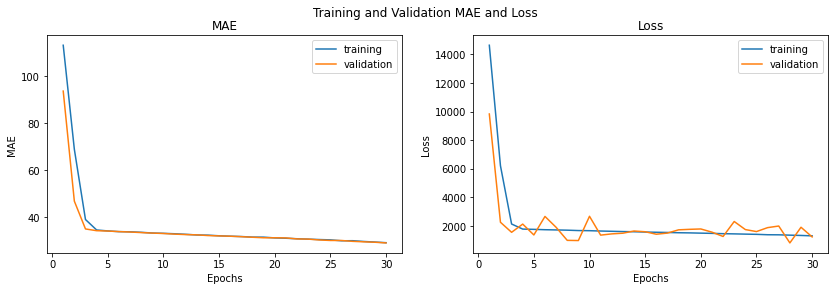

In [0]:
plot_history(trained_models['model_1']['result'])
model_params_results('model_1')

In [0]:
trained_models = train_and_save('model_2')

Epoch 1/30
 - 212s - loss: 17584.6777 - mae: 126.0099 - val_loss: 17499.8125 - val_mae: 124.9680
Epoch 2/30
 - 201s - loss: 16862.7943 - mae: 123.1560 - val_loss: 16023.4600 - val_mae: 121.6233
Epoch 3/30
 - 202s - loss: 16086.4521 - mae: 120.0202 - val_loss: 16264.2529 - val_mae: 118.4717
Epoch 4/30
 - 202s - loss: 15150.2846 - mae: 115.9637 - val_loss: 14283.4199 - val_mae: 114.4120
Epoch 5/30
 - 202s - loss: 14298.6626 - mae: 112.2345 - val_loss: 13560.0430 - val_mae: 110.5297
Epoch 6/30
 - 200s - loss: 13383.3575 - mae: 108.0578 - val_loss: 13060.1533 - val_mae: 106.1693
Epoch 7/30
 - 202s - loss: 12438.8797 - mae: 103.8080 - val_loss: 12262.9062 - val_mae: 101.5085
Epoch 8/30
 - 202s - loss: 11447.9347 - mae: 98.9142 - val_loss: 10094.3418 - val_mae: 96.5223
Epoch 9/30
 - 202s - loss: 10458.2098 - mae: 94.0073 - val_loss: 8703.9922 - val_mae: 91.5923
Epoch 10/30
 - 203s - loss: 9510.2094 - mae: 88.9831 - val_loss: 8066.4316 - val_mae: 86.1151
Epoch 11/30
 - 204s - loss: 8409.4339 

Parameters of model_2: {'trainable': 'none', 'dense_hidden_neurons': 16, 'lr': 0.0001}
Best validation loss loss of model_2: 1468.87
Best validation MAE of model_2: 34.29 months


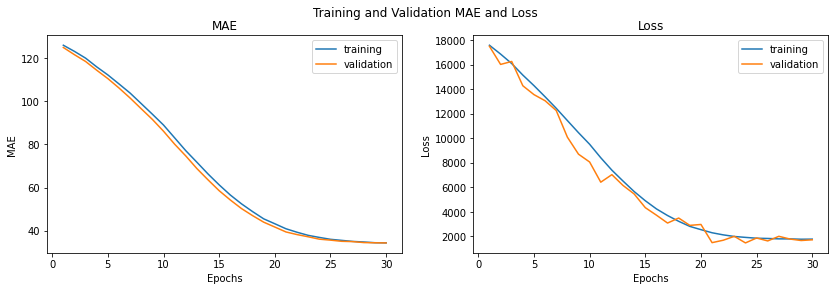

In [0]:
plot_history(trained_models['model_2']['result'])
model_params_results('model_2')

In [0]:
trained_models = train_and_save('model_3')

Epoch 1/30
 - 225s - loss: 13158.5023 - mae: 106.3456 - val_loss: 7611.1196 - val_mae: 76.6326
Epoch 2/30
 - 206s - loss: 3578.6183 - mae: 50.6006 - val_loss: 1868.5519 - val_mae: 35.8911
Epoch 3/30
 - 209s - loss: 1771.2642 - mae: 34.3714 - val_loss: 1460.0780 - val_mae: 33.9163
Epoch 4/30
 - 210s - loss: 1736.8954 - mae: 33.6690 - val_loss: 1581.2086 - val_mae: 33.7180
Epoch 5/30
 - 209s - loss: 1717.1524 - mae: 33.4549 - val_loss: 1626.3203 - val_mae: 33.4415
Epoch 6/30
 - 210s - loss: 1694.8413 - mae: 33.2193 - val_loss: 957.8491 - val_mae: 33.2237
Epoch 7/30
 - 209s - loss: 1673.8854 - mae: 32.9894 - val_loss: 1303.0278 - val_mae: 33.0612
Epoch 8/30
 - 210s - loss: 1649.9473 - mae: 32.7440 - val_loss: 2315.5908 - val_mae: 32.7487
Epoch 9/30
 - 209s - loss: 1637.1154 - mae: 32.5373 - val_loss: 1482.2856 - val_mae: 32.5973
Epoch 10/30
 - 209s - loss: 1614.5176 - mae: 32.3571 - val_loss: 1424.7284 - val_mae: 32.3928
Epoch 11/30
 - 209s - loss: 1597.3991 - mae: 32.1465 - val_loss: 127

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 53638, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

Parameters of model_3: {'trainable': 'none', 'dense_hidden_neurons': 32, 'lr': 0.001}
Best validation loss loss of model_3: 741.6
Best validation MAE of model_3: 27.41 months


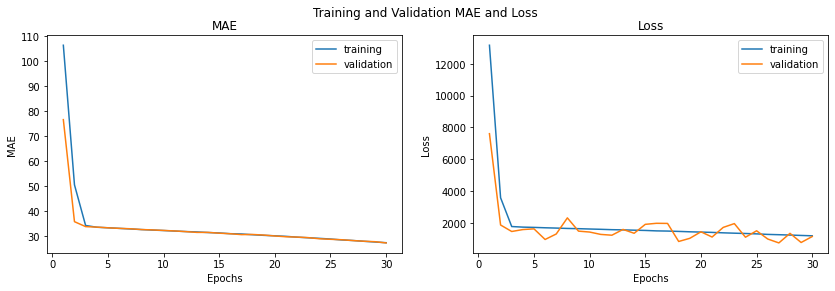

In [0]:
plot_history(trained_models['model_3']['result'])
model_params_results('model_3')

In [0]:
trained_models = train_and_save('model_4')

Epoch 1/30
 - 221s - loss: 17779.4446 - mae: 126.8394 - val_loss: 16933.9727 - val_mae: 125.7265
Epoch 2/30
 - 215s - loss: 17158.4879 - mae: 124.3205 - val_loss: 14712.7578 - val_mae: 123.4627
Epoch 3/30
 - 212s - loss: 16635.7892 - mae: 122.2385 - val_loss: 15405.7031 - val_mae: 121.0778
Epoch 4/30
 - 210s - loss: 15904.9002 - mae: 119.1987 - val_loss: 17129.5547 - val_mae: 118.0562
Epoch 5/30
 - 211s - loss: 15102.5313 - mae: 115.7481 - val_loss: 16498.4980 - val_mae: 114.3021
Epoch 6/30
 - 211s - loss: 14190.0867 - mae: 111.8102 - val_loss: 14255.6523 - val_mae: 109.1210
Epoch 7/30
 - 211s - loss: 13070.1798 - mae: 106.6655 - val_loss: 13270.7578 - val_mae: 103.8518
Epoch 8/30
 - 212s - loss: 11854.2748 - mae: 100.9867 - val_loss: 10688.5410 - val_mae: 98.0593
Epoch 9/30
 - 211s - loss: 10702.5556 - mae: 95.1554 - val_loss: 9675.3242 - val_mae: 92.5510
Epoch 10/30
 - 211s - loss: 9646.7015 - mae: 89.7347 - val_loss: 8773.0547 - val_mae: 86.5945
Epoch 11/30
 - 210s - loss: 8499.4378

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 44584, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

Parameters of model_4: {'trainable': 'none', 'dense_hidden_neurons': 32, 'lr': 0.0001}
Best validation loss loss of model_4: 1314.83
Best validation MAE of model_4: 34.08 months


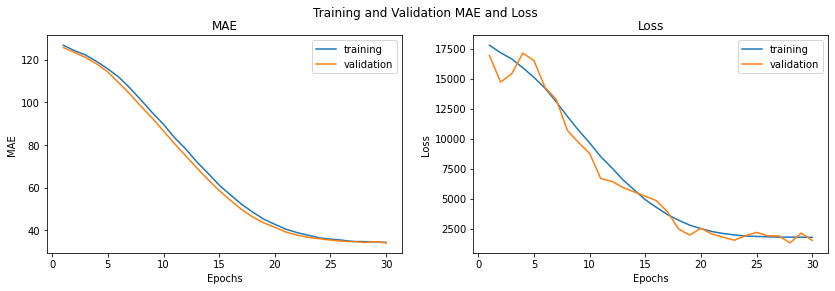

In [0]:
plot_history(trained_models['model_4']['result'])
model_params_results('model_4')

In [0]:
trained_models = train_and_save('model_5')

Epoch 1/30
 - 199s - loss: 2358.6993 - mae: 38.0482 - val_loss: 856.6633 - val_mae: 31.6402
Epoch 2/30
 - 187s - loss: 1427.2508 - mae: 30.7247 - val_loss: 1192.5890 - val_mae: 29.3934
Epoch 3/30
 - 190s - loss: 1212.7650 - mae: 28.1413 - val_loss: 973.1726 - val_mae: 26.6025
Epoch 4/30
 - 190s - loss: 1031.6693 - mae: 25.6207 - val_loss: 888.4509 - val_mae: 23.9863
Epoch 5/30
 - 190s - loss: 903.2823 - mae: 23.7605 - val_loss: 775.1056 - val_mae: 22.9777
Epoch 6/30
 - 191s - loss: 826.0305 - mae: 22.4599 - val_loss: 609.7675 - val_mae: 21.3202
Epoch 7/30
 - 193s - loss: 760.6503 - mae: 21.3601 - val_loss: 426.0384 - val_mae: 20.3824
Epoch 8/30
 - 193s - loss: 694.3778 - mae: 20.3962 - val_loss: 960.7745 - val_mae: 20.3748
Epoch 9/30
 - 195s - loss: 669.8544 - mae: 19.8929 - val_loss: 1071.0781 - val_mae: 20.4742
Epoch 10/30
 - 196s - loss: 631.0528 - mae: 19.2402 - val_loss: 1289.6144 - val_mae: 23.2841
Epoch 11/30
 - 194s - loss: 630.4572 - mae: 19.2841 - val_loss: 1063.2716 - val_ma

Parameters of model_5: {'trainable': 'last_layer', 'dense_hidden_neurons': 16, 'lr': 0.001}
Best validation loss loss of model_5: 241.84
Best validation MAE of model_5: 15.67 months


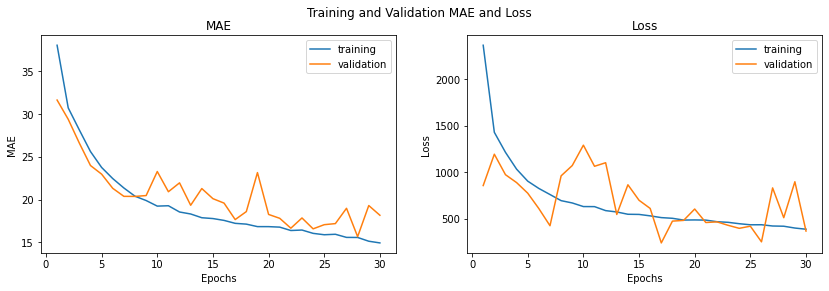

In [0]:
plot_history(trained_models['model_5']['result'])
model_params_results('model_5')

In [0]:
trained_models = train_and_save('model_6')

Epoch 1/30
 - 206s - loss: 5796.0011 - mae: 60.8129 - val_loss: 1776.2299 - val_mae: 34.6326
Epoch 2/30
 - 196s - loss: 1735.2456 - mae: 33.9214 - val_loss: 1808.0347 - val_mae: 33.2149
Epoch 3/30
 - 196s - loss: 1588.5507 - mae: 32.5310 - val_loss: 1594.6831 - val_mae: 31.8329
Epoch 4/30
 - 197s - loss: 1478.4230 - mae: 31.3524 - val_loss: 1150.5629 - val_mae: 30.4770
Epoch 5/30
 - 199s - loss: 1363.5401 - mae: 30.1132 - val_loss: 1489.4102 - val_mae: 29.4611
Epoch 6/30
 - 198s - loss: 1251.2683 - mae: 28.7083 - val_loss: 1237.0126 - val_mae: 27.8979
Epoch 7/30
 - 193s - loss: 1142.1682 - mae: 27.2458 - val_loss: 992.5311 - val_mae: 26.5693
Epoch 8/30
 - 191s - loss: 1070.7675 - mae: 26.1616 - val_loss: 1277.3025 - val_mae: 25.6156
Epoch 9/30
 - 190s - loss: 992.9359 - mae: 25.0286 - val_loss: 1135.6316 - val_mae: 24.4486
Epoch 10/30
 - 189s - loss: 946.4101 - mae: 24.3980 - val_loss: 1126.4142 - val_mae: 24.3113
Epoch 11/30
 - 190s - loss: 908.0592 - mae: 23.6252 - val_loss: 903.2368

Parameters of model_6: {'trainable': 'last_layer', 'dense_hidden_neurons': 16, 'lr': 0.0001}
Best validation loss loss of model_6: 420.44
Best validation MAE of model_6: 19.87 months


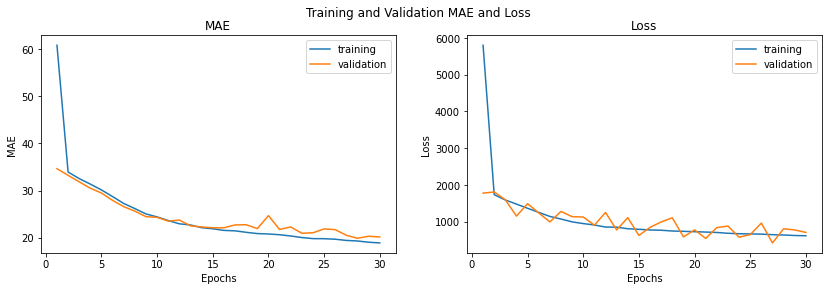

In [0]:
plot_history(trained_models['model_6']['result'])
model_params_results('model_6')

In [0]:
trained_models = train_and_save('model_7')

Epoch 1/30
 - 204s - loss: 2381.0071 - mae: 38.0004 - val_loss: 1523.2291 - val_mae: 31.4454
Epoch 2/30
 - 194s - loss: 1410.8787 - mae: 30.6076 - val_loss: 1357.8307 - val_mae: 28.7909
Epoch 3/30
 - 196s - loss: 1150.0187 - mae: 27.3077 - val_loss: 1164.5912 - val_mae: 25.5372
Epoch 4/30
 - 196s - loss: 954.6869 - mae: 24.4261 - val_loss: 690.5375 - val_mae: 23.1993
Epoch 5/30
 - 195s - loss: 851.9131 - mae: 22.7551 - val_loss: 964.1014 - val_mae: 21.7841
Epoch 6/30
 - 194s - loss: 778.5653 - mae: 21.6494 - val_loss: 568.8764 - val_mae: 21.5481
Epoch 7/30
 - 194s - loss: 715.0074 - mae: 20.5904 - val_loss: 508.6450 - val_mae: 19.8485
Epoch 8/30
 - 195s - loss: 646.2952 - mae: 19.5843 - val_loss: 696.0392 - val_mae: 18.8777
Epoch 9/30
 - 192s - loss: 625.6503 - mae: 19.0550 - val_loss: 920.6999 - val_mae: 22.0541
Epoch 10/30
 - 197s - loss: 595.7941 - mae: 18.5895 - val_loss: 743.2460 - val_mae: 20.4571
Epoch 11/30
 - 196s - loss: 544.4248 - mae: 17.8050 - val_loss: 418.6115 - val_mae:

Parameters of model_7: {'trainable': 'last_layer', 'dense_hidden_neurons': 32, 'lr': 0.001}
Best validation loss loss of model_7: 302.16
Best validation MAE of model_7: 14.09 months


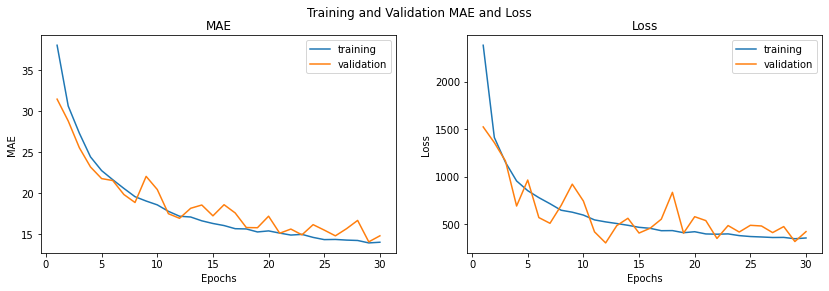

In [0]:
plot_history(trained_models['model_7']['result'])
model_params_results('model_7')

In [0]:
trained_models = train_and_save('model_8')

Epoch 1/30
 - 266s - loss: 6994.2782 - mae: 68.1141 - val_loss: 1962.4595 - val_mae: 34.3851
Epoch 2/30
 - 250s - loss: 1761.5164 - mae: 34.1775 - val_loss: 1491.8422 - val_mae: 34.0486
Epoch 3/30
 - 247s - loss: 1620.2398 - mae: 32.9035 - val_loss: 1212.8110 - val_mae: 31.5323
Epoch 4/30
 - 245s - loss: 1493.4156 - mae: 31.5040 - val_loss: 1292.6517 - val_mae: 31.0656
Epoch 5/30
 - 246s - loss: 1361.1475 - mae: 30.1007 - val_loss: 1706.2604 - val_mae: 29.0466
Epoch 6/30
 - 248s - loss: 1225.6102 - mae: 28.4015 - val_loss: 1135.2198 - val_mae: 27.2995
Epoch 7/30
 - 247s - loss: 1111.4695 - mae: 26.8671 - val_loss: 1242.9187 - val_mae: 26.1870
Epoch 8/30
 - 246s - loss: 1023.2583 - mae: 25.5354 - val_loss: 1055.6638 - val_mae: 25.3310
Epoch 9/30
 - 248s - loss: 977.5637 - mae: 24.8313 - val_loss: 818.4676 - val_mae: 24.2614
Epoch 10/30
 - 250s - loss: 926.4289 - mae: 23.9758 - val_loss: 1046.8812 - val_mae: 23.1705
Epoch 11/30
 - 247s - loss: 862.2848 - mae: 23.0567 - val_loss: 960.6721

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 59876, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

Parameters of model_8: {'trainable': 'last_layer', 'dense_hidden_neurons': 32, 'lr': 0.0001}
Best validation loss loss of model_8: 449.98
Best validation MAE of model_8: 19.0 months


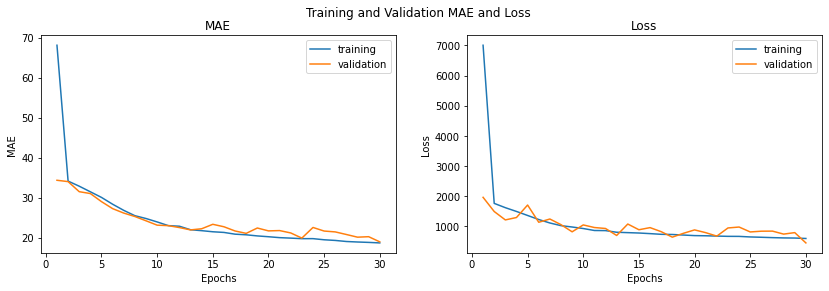

In [0]:
plot_history(trained_models['model_8']['result'])
model_params_results('model_8')

In [0]:
trained_models = train_and_save('model_9')

Epoch 1/30
 - 212s - loss: 1666.1325 - mae: 31.4405 - val_loss: 941.0478 - val_mae: 22.2179
Epoch 2/30
 - 197s - loss: 654.6157 - mae: 19.8863 - val_loss: 378.1566 - val_mae: 18.0006
Epoch 3/30
 - 196s - loss: 558.6621 - mae: 18.2383 - val_loss: 389.7158 - val_mae: 16.4863
Epoch 4/30
 - 198s - loss: 443.4131 - mae: 16.2776 - val_loss: 423.8894 - val_mae: 16.2376
Epoch 5/30
 - 195s - loss: 417.6713 - mae: 15.8263 - val_loss: 461.8576 - val_mae: 16.5212
Epoch 6/30
 - 201s - loss: 410.4625 - mae: 15.6131 - val_loss: 443.7120 - val_mae: 15.2585
Epoch 7/30
 - 198s - loss: 349.7832 - mae: 14.2714 - val_loss: 336.6071 - val_mae: 14.7741
Epoch 8/30
 - 197s - loss: 345.3158 - mae: 14.1207 - val_loss: 428.8592 - val_mae: 13.7766
Epoch 9/30
 - 196s - loss: 331.7956 - mae: 13.9009 - val_loss: 559.5464 - val_mae: 15.1898
Epoch 10/30
 - 195s - loss: 292.3944 - mae: 12.9677 - val_loss: 222.3865 - val_mae: 12.7509
Epoch 11/30
 - 194s - loss: 287.7863 - mae: 12.7844 - val_loss: 385.4878 - val_mae: 14.5

Parameters of model_9: {'trainable': 'last_block', 'dense_hidden_neurons': 16, 'lr': 0.001}
Best validation loss loss of model_9: 111.19
Best validation MAE of model_9: 10.69 months


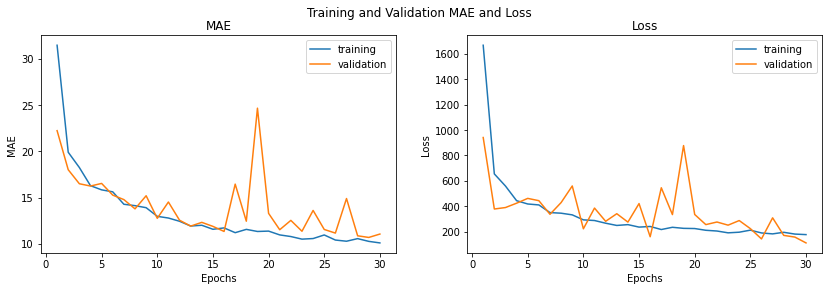

In [0]:
plot_history(trained_models['model_9']['result'])
model_params_results('model_9')

In [0]:
trained_models = train_and_save('model_10')

Epoch 1/30
 - 215s - loss: 3286.7576 - mae: 43.4615 - val_loss: 1358.3684 - val_mae: 29.8771
Epoch 2/30
 - 206s - loss: 1075.0284 - mae: 26.0559 - val_loss: 818.5135 - val_mae: 23.7170
Epoch 3/30
 - 206s - loss: 741.8300 - mae: 21.0641 - val_loss: 689.9243 - val_mae: 19.7031
Epoch 4/30
 - 207s - loss: 641.9161 - mae: 19.4599 - val_loss: 709.0475 - val_mae: 18.2202
Epoch 5/30
 - 206s - loss: 549.5465 - mae: 17.9073 - val_loss: 653.7660 - val_mae: 17.8773
Epoch 6/30
 - 209s - loss: 519.2121 - mae: 17.4445 - val_loss: 377.7172 - val_mae: 17.2211
Epoch 7/30
 - 210s - loss: 453.7921 - mae: 16.3362 - val_loss: 704.3068 - val_mae: 17.6007
Epoch 8/30
 - 208s - loss: 436.9649 - mae: 15.9877 - val_loss: 433.4729 - val_mae: 15.4192
Epoch 9/30
 - 207s - loss: 403.8419 - mae: 15.4692 - val_loss: 483.0381 - val_mae: 15.9823
Epoch 10/30
 - 208s - loss: 397.4631 - mae: 15.3531 - val_loss: 297.4205 - val_mae: 14.6414
Epoch 11/30
 - 209s - loss: 366.9139 - mae: 14.7974 - val_loss: 476.5446 - val_mae: 16

Parameters of model_10: {'trainable': 'last_block', 'dense_hidden_neurons': 16, 'lr': 0.0001}
Best validation loss loss of model_10: 190.0
Best validation MAE of model_10: 12.81 months


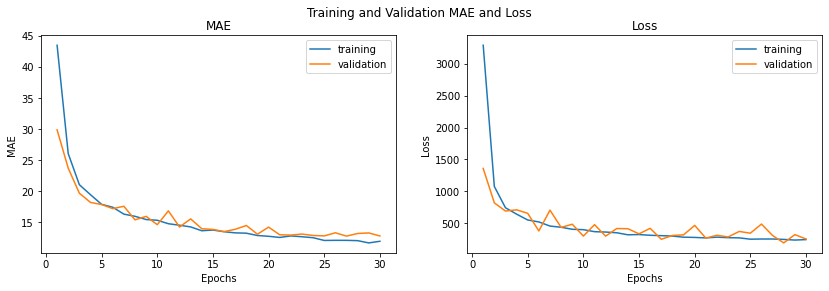

In [0]:
plot_history(trained_models['model_10']['result'])
model_params_results('model_10')

In [0]:
trained_models = train_and_save('model_11')

Epoch 1/30
 - 207s - loss: 3029.1740 - mae: 41.2351 - val_loss: 1090.4890 - val_mae: 28.3476
Epoch 2/30
 - 190s - loss: 953.6777 - mae: 24.2970 - val_loss: 662.6518 - val_mae: 23.7883
Epoch 3/30
 - 187s - loss: 648.2908 - mae: 19.6301 - val_loss: 914.9734 - val_mae: 20.7355
Epoch 4/30
 - 185s - loss: 572.9000 - mae: 18.5023 - val_loss: 577.9620 - val_mae: 17.0113
Epoch 5/30
 - 184s - loss: 494.0067 - mae: 17.1386 - val_loss: 377.3887 - val_mae: 15.8853
Epoch 6/30
 - 184s - loss: 437.2487 - mae: 15.9902 - val_loss: 354.5317 - val_mae: 15.6724
Epoch 7/30
 - 184s - loss: 409.3150 - mae: 15.5701 - val_loss: 549.6782 - val_mae: 15.2962
Epoch 8/30
 - 184s - loss: 381.3887 - mae: 14.9871 - val_loss: 456.6073 - val_mae: 14.1711
Epoch 9/30
 - 191s - loss: 330.8475 - mae: 13.7451 - val_loss: 224.8420 - val_mae: 13.7195
Epoch 10/30
 - 198s - loss: 337.0682 - mae: 14.0070 - val_loss: 327.5414 - val_mae: 13.9514
Epoch 11/30
 - 201s - loss: 295.4843 - mae: 12.9774 - val_loss: 195.9068 - val_mae: 13.

Parameters of model_11: {'trainable': 'last_block', 'dense_hidden_neurons': 32, 'lr': 0.001}
Best validation loss loss of model_11: 133.22
Best validation MAE of model_11: 10.64 months


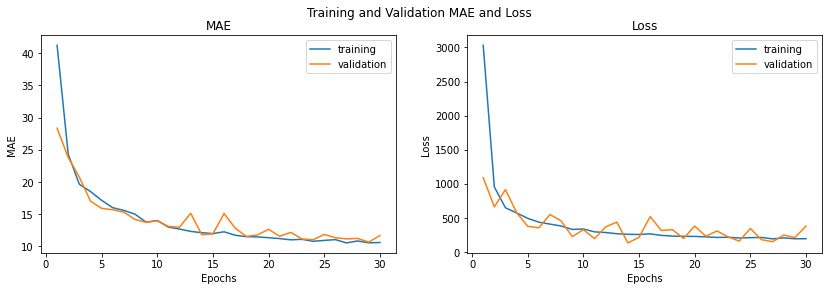

In [0]:
plot_history(trained_models['model_11']['result'])
model_params_results('model_11')

In [0]:
trained_models = train_and_save('model_12')

Epoch 1/30
 - 218s - loss: 2692.6284 - mae: 39.7906 - val_loss: 1217.6537 - val_mae: 28.3422
Epoch 2/30
 - 207s - loss: 976.0033 - mae: 24.6482 - val_loss: 734.7205 - val_mae: 21.4294
Epoch 3/30
 - 207s - loss: 719.4885 - mae: 20.6762 - val_loss: 530.1798 - val_mae: 19.5117
Epoch 4/30
 - 207s - loss: 631.7259 - mae: 19.3100 - val_loss: 799.5493 - val_mae: 19.1827
Epoch 5/30
 - 207s - loss: 543.4449 - mae: 17.8755 - val_loss: 535.8974 - val_mae: 17.8837
Epoch 6/30
 - 207s - loss: 497.5524 - mae: 17.1113 - val_loss: 323.1884 - val_mae: 16.5411
Epoch 7/30
 - 207s - loss: 439.6174 - mae: 16.0960 - val_loss: 417.1238 - val_mae: 16.2564
Epoch 8/30
 - 207s - loss: 409.9089 - mae: 15.5546 - val_loss: 519.0242 - val_mae: 15.6883
Epoch 9/30
 - 207s - loss: 392.3280 - mae: 15.2424 - val_loss: 349.9881 - val_mae: 17.0557
Epoch 10/30
 - 207s - loss: 387.2416 - mae: 15.1729 - val_loss: 581.4922 - val_mae: 14.6880
Epoch 11/30
 - 207s - loss: 356.4548 - mae: 14.5626 - val_loss: 366.3558 - val_mae: 14.

Parameters of model_12: {'trainable': 'last_block', 'dense_hidden_neurons': 32, 'lr': 0.0001}
Best validation loss loss of model_12: 153.21
Best validation MAE of model_12: 11.97 months


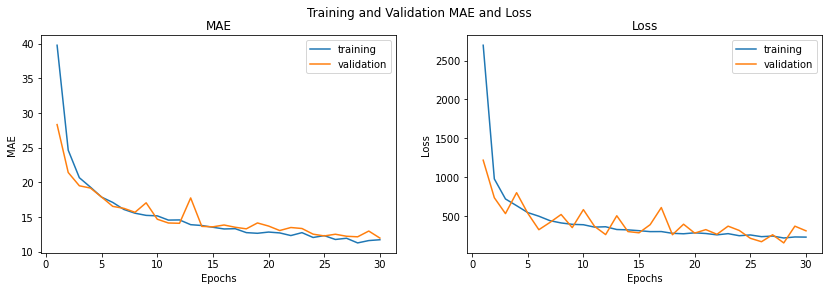

In [0]:
plot_history(trained_models['model_12']['result'])
model_params_results('model_12')

### Evaluate best model

In [0]:
best_val_mae = np.min([info['result']['val_mae'] for model, info in trained_models.items()])
best_model_nr = [model for model, info in trained_models.items() 
                 if np.min(info['result']['val_mae'])==best_val_mae][0]

In [0]:
best_model = load_model('keras_weights_{}.hdf5'.format(best_model_nr))

In [0]:
result = best_model.evaluate_generator(test_generator, steps=1)
print('The final model achieves a MAE of {} on the test set.'.format(round(result[1],2)))
print('The final model achieves a MSE of {} on the test set.'.format(round(result[0],2)))

The final model achieves a MAE of 15.9 on the test set.
The final model achieves a MSE of 440.18 on the test set.


#### Plot some test images

In [0]:
test_generator = custom_generator(test, 200, datagen, 'test', shuffle=False)
y_hats = best_model.predict_generator(test_generator, steps=1)
y_true = test['boneage'].values

In [0]:
mean_absolute_error(y_true, y_hats)

15.896390924453735

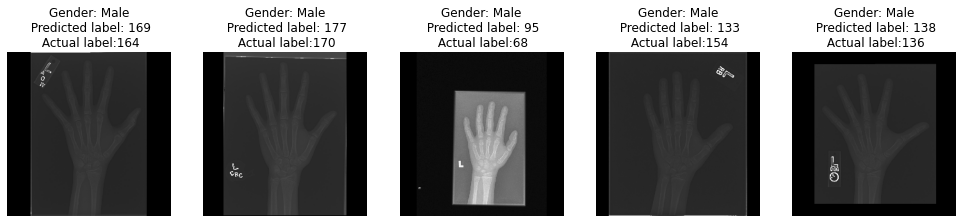

In [0]:
test_images = []
for i in range(5):
    test_image = krs_image.load_img(test.iloc[i,2], target_size=(256, 256))
    test_image = krs_image.img_to_array(test_image)
    test_image = test_image * (1./255)
    test_images.append(test_image)

fig, axes = plt.subplots(1, len(test_images), figsize=(17, 5))
for idx, ax in enumerate(axes):
    ax.axis('off')
    ax.imshow(test_images[idx])
    ax.set_title('Gender: {}\n Predicted label: {}\n Actual label:{}'.format(
        'Male' if test.iloc[idx, 4]==1 else 'Female',
        int(round(y_hats[idx][0])), 
        y_true[idx]))

#### Some insight in activations

I will plot here the activations of the 512 filters in the last convolutional layer of the VGG16 model.

In [0]:
import keract

In [0]:
test_generator = custom_generator(test, 10, datagen, 'test')
X, y = next(test_generator)
x_img, x_gender = X
x = [x_img[0].reshape(-1, 256, 256, 3), x_gender[0].reshape(-1)]

block5_conv3 (1, 16, 16, 512) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

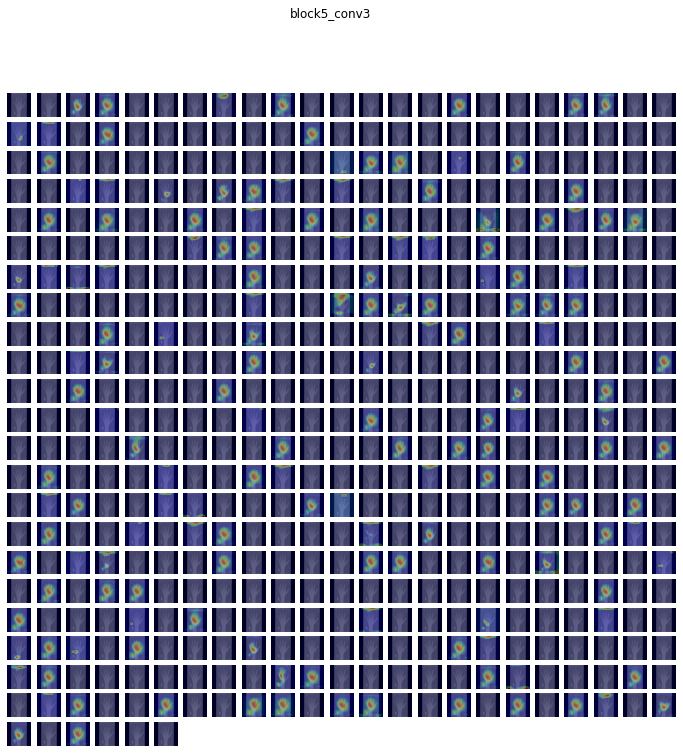

In [0]:
activations = keract.get_activations(best_model, x, layer_name='block5_conv3')
keract.display_heatmaps(activations, x_img[0]*512)